### Section 1: Business Understanding 
AirBnB is a company, which provides internet services for customer, who temporary wants to share their home with others.  
This Notebook adresses both people, who are interested in unterstanding data provided by AirBnB and people, who are interested to use AirBnb in Seattle and to get some information about the situation in the city.    
With the given data, following question will be adressed:
1. how ist the AirBnB market in Seattle?
 1. how many listings do exist?
 2. what ist the average price, how is its distribution over the year?
 3. what is the average availability, how is its distribution over the year?
 4. is there a correlation between price, availabilty and the climate in Seattle (which would give a view on the	tourist potential of the city)
 5. how ist the distribution of the listings over the neighborhoods and in general over the city in terms of numbers, prices, ratings and property type?
2. how can written reviews used for data analysis?
  1. is it possible to quantify them using a "SentimentIntensityAnalyzer"?
  2. what are the pitfalls if doing so?
  3. is there a correlation between the polarity_scores from a SentimentIntensityAnalyzer and the direct rating scores from the customer?
3. how can the price be predicted using a data-based model?
  1. which data best fit to the model?
  
The answers can be found in section 5: Evaluation
    

### Section 2: Data Understanding

  

To start the data analysis, necessary packages will be loaded and setting are done:

In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline
sns.set_theme(style="darkgrid")

definition of some helper-functions to process string-based operations:

In [2]:

# definitions of functions for data-processing

def char2Bool(input_col):
    '''
    INPUT
    input_col - pandas series 
    
    OUTPUT
    output_col - pandas series 
    
    This function changes input_col using the following steps:
    1. replace all character 't' by the bool True
    2. replace all character 'f' by the bool False
    '''
    
    input_col = input_col.replace('t', True)
    output_col = input_col.replace('f', False)
    return (output_col)
    
def price2numeric(input_col):
    '''
    INPUT
    input_col - pandas series 
    
    OUTPUT
    output_col - pandas series 
    
    This function changes input_col using the following steps:
    1. delete all character ','
    2. delete all character '$'
    3. delete all character '.00'
    4. change dtype of values from string to numeric
    '''
    input_col = input_col.str.replace(',', '')
    input_col = input_col.str.replace('$', '')
    output_col = input_col.str.replace('.00', '')
    return (pd.to_numeric(output_col))

def clean_str(input_col):
    '''
    INPUT
    input_col - pandas series 
    
    OUTPUT
    output_col - pandas series 
    
    This function changes input_col using the following steps:
    1. delete all character '{'
    2. delete all character '}'
    3. delete all character '"'
    '''
    input_col = input_col.str.replace('{', '')
    input_col = input_col.str.replace('}', '')
    output_col = input_col.str.replace('"', '')
    return (output_col)



Now the data can be loaded and a very first look on the data can be made.  
First the **calender** data set:
### gather data

In [3]:
# load calendar data set
df_calendar = pd.read_csv('./seattle/calendar.csv')

# show first 5 rows
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
# number of rows and columns
print("Number of rows and columns: ", df_calendar.shape)

Number of rows and columns:  (1393570, 4)


In [5]:
# how many values are missing?
print(df_calendar.isnull().sum())

listing_id         0
date               0
available          0
price         459028
dtype: int64


In [6]:
# Describe
print(df_calendar.describe(include='all'))

          listing_id        date available    price
count   1.393570e+06     1393570   1393570   934542
unique           NaN         365         2      669
top              NaN  2016-11-24         t  $150.00
freq             NaN        3818    934542    36646
mean    5.550111e+06         NaN       NaN      NaN
std     2.962274e+06         NaN       NaN      NaN
min     3.335000e+03         NaN       NaN      NaN
25%     3.258213e+06         NaN       NaN      NaN
50%     6.118244e+06         NaN       NaN      NaN
75%     8.035212e+06         NaN       NaN      NaN
max     1.034016e+07         NaN       NaN      NaN


**listings** data set:

In [7]:
# load listings data set
df_listings = pd.read_csv('./seattle/listings.csv')

# set id as index (is needed later when outer data is joined...)
df_listings = df_listings.set_index('id')

# show first 5 rows
print (df_listings.head())   

                                  listing_url       scrape_id last_scraped  \
id                                                                           
241032    https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
953595    https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
278830    https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                        name  \
id                                             
241032          Stylish Queen Anne Apartment   
953595    Bright & Airy Queen Anne Apartment   
3308979  New Modern House-Amazing water view   
7421966                   Queen Anne Chateau   
278830        Charming craftsman 3 bdm house   

                                                   summary  \
id                                                    

In [8]:
# how many values are missing?
print(df_listings.isnull().sum())

listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
summary                             177
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 91, dtype: int64


In [9]:
# Describe
print(df_listings.describe(include='all'))

                                 listing_url     scrape_id last_scraped  \
count                                   3818  3.818000e+03         3818   
unique                                  3818           NaN            1   
top     https://www.airbnb.com/rooms/3147706           NaN   2016-01-04   
freq                                       1           NaN         3818   
mean                                     NaN  2.016010e+13          NaN   
std                                      NaN  0.000000e+00          NaN   
min                                      NaN  2.016010e+13          NaN   
25%                                      NaN  2.016010e+13          NaN   
50%                                      NaN  2.016010e+13          NaN   
75%                                      NaN  2.016010e+13          NaN   
max                                      NaN  2.016010e+13          NaN   

                          name  \
count                     3818   
unique                    3792 

**Review** data set:

In [10]:
# load reviews data set
df_reviews = pd.read_csv('./seattle/reviews.csv')

# show first 5 rows
print(df_reviews.head())

   listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...  


In [11]:
# number of rows and columns
print("Number of rows and columns: ", df_reviews.shape)

Number of rows and columns:  (84849, 6)


In [12]:
# how many values are missing?
print(df_reviews.isnull().sum())

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64


In [13]:
# Describe
print(df_reviews.describe(include='all'))

          listing_id            id        date   reviewer_id reviewer_name  \
count   8.484900e+04  8.484900e+04       84849  8.484900e+04         84849   
unique           NaN           NaN        1930           NaN         14380   
top              NaN           NaN  2015-09-21           NaN         David   
freq             NaN           NaN         580           NaN           870   
mean    3.005067e+06  3.058765e+07         NaN  1.701301e+07           NaN   
std     2.472877e+06  1.636613e+07         NaN  1.353704e+07           NaN   
min     4.291000e+03  3.721000e+03         NaN  1.500000e+01           NaN   
25%     7.946330e+05  1.725127e+07         NaN  5.053141e+06           NaN   
50%     2.488228e+06  3.228809e+07         NaN  1.413476e+07           NaN   
75%     4.694479e+06  4.457648e+07         NaN  2.762402e+07           NaN   
max     1.024814e+07  5.873651e+07         NaN  5.281274e+07           NaN   

                                                 comments  
cou

As we have now a better overview about the data, we take a closer look.
We first focus on the data set "calendar".
To prepare the data for the next questions, new colums for month and year are extracted from column "date".
We also need the data for the price in numeric format (also in data-set "listings", as we need them later).
Also, we convert the data for "availability" to real boolean values.
Finally, as the timerange of the data is 01/2016 - 01/2017 and we want to have the overview over 1 year, we drop the data for 2017:

In [14]:
# extract year and month from date
df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month

# price to numeric
df_calendar['price'] = price2numeric(df_calendar['price'])
df_listings['price'] = price2numeric(df_listings['price'])

# availability to bool
df_calendar['available'] = char2Bool(df_calendar['available'])

transform human-written reviews into polarity_scores:

In [15]:
# create analyzer
analyzer = SentimentIntensityAnalyzer()

# function to calculate polarity_scores
def get_polarity_scores(review_text):
    '''
    INPUT
    review_text - text to be assessed (string )
    
    OUTPUT
    output_col - polarity_scores (float 0 - 1)
    
    This function calculates the polarity_scores based on the input-text
    using the SentimentIntensityAnalyzer from nltk.sentiment.vader
    '''
    return analyzer.polarity_scores(review_text)['compound']

# remove NANs from reviews
df_reviews = df_reviews.dropna(subset = ['comments'])

- create new column with polarity_scores

In [16]:
# add polarity_scores of reviews
df_reviews['polarity_scores'] = df_reviews['comments'].apply(get_polarity_scores)

Now let's compare polarity_scores to the ratings of the listings:  
For that, we have to:  
- calculate the mean polarity_score for each listing and
- join these polarity_scores to the linting data set
    

In [17]:
# mean polarity_scores per listing
df_reviews_mean_per_listing = df_reviews.groupby(['listing_id']).mean()

# add polarity_scores to listings
df_listings = df_listings.join(df_reviews_mean_per_listing['polarity_scores'])

### Section 3: Data Preparation
After we got a good overview about the data we are dealing with, data has to be prepared, so that it can be fed to a linear model, which will predict prices from given data.
The following question will be adressed:
1. which data can be used?
    a. how to prepare the target data?
    b. which numerical data can be used as features?
    c. which categorical data can be used as features?
    c. how do we deal with missing data?
    d...
    
2. which data really make sense to use?
    a. how is the correllation to the cvalue to be predicted?
    b. how many differend numerical and categoical  data shall be used, to get the best results
    c. how many different categorys within a categorical data should be used?
    
3. what can we do to avoid overfitting?

As stated above, the goal is to predict the prices using relevant data as features.
To use the prices as targets, they need to be in a numerical format. We did that already when analysing the data.We only will use listing with valid prices:

In [18]:
# drop all rows with price as NAN
df_listings = df_listings.dropna(subset=['price'])

to get a good set of features, we can drop all non-categorical and non-relevant numerical data:

In [19]:
# drop all non-numerical- or categorical columns:'neighbourhood_group_cleansed',
non_num_cat = ['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'picture_url', 'host_name',
       'host_since', 'host_location', 'host_about','listing_url','last_scraped',
       'thumbnail_url','medium_url','xl_picture_url','host_url','host_thumbnail_url',
       'street','zipcode','smart_location','country','calendar_updated',
       'calendar_last_scraped','first_review','last_review','host_picture_url', 'host_neighbourhood', 'neighbourhood',  'city', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'jurisdiction_names',
       'state', 'market', 'country_code', 'is_location_exact']
df_listings = df_listings.drop(non_num_cat, axis=1)

# non-relevant numerical values
non_rel_num = ['scrape_id','host_id','host_verifications','square_feet','license']
df_listings = df_listings.drop(non_rel_num, axis=1)

Now we want to find out, which numerical data we can use as features to predict the price as target.
For that, we visualize the correllation between features and target:

<AxesSubplot:>

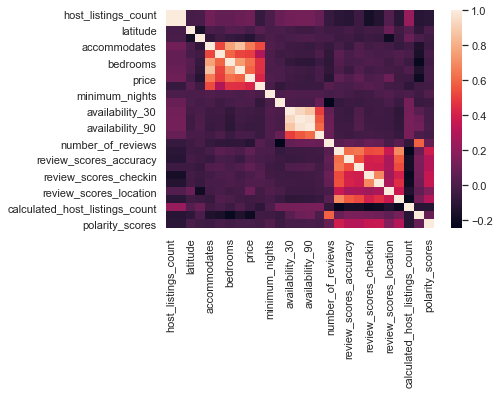

In [20]:
# filter for numerical features
df_listings_num = df_listings.select_dtypes(exclude=['object'])

# normalize numerical features
df_listings_num = (df_listings_num - df_listings_num.mean())/df_listings_num.std()

# calculate correlation matrix to see, which numeric values are correllated to the price
df_listings_num_cov = df_listings_num.cov()

# display correllation as heat-map
sns.heatmap(df_listings_num_cov)


we can see now the TOP10 of the features, which are correlated to the price. We will use the best correlated feattures to train our model.

In [21]:
df_listings_num_cov.sort_values(['price'],ascending = False).index[1:10]

Index(['accommodates', 'bedrooms', 'beds', 'bathrooms', 'guests_included',
       'host_total_listings_count', 'host_listings_count',
       'review_scores_location', 'review_scores_cleanliness'],
      dtype='object')

In [22]:
key_mean = df_listings_num.columns

Are there any missing numerical data?

In [23]:
df_listings[key_mean].isnull().sum()

host_listings_count                 2
host_total_listings_count           2
latitude                            0
longitude                           0
accommodates                        0
bathrooms                          16
bedrooms                            5
beds                                1
price                               0
guests_included                     0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
review_scores_rating              569
review_scores_accuracy            579
review_scores_cleanliness         574
review_scores_checkin             579
review_scores_communication       572
review_scores_location            576
review_scores_value               577
calculated_host_listings_count      0
reviews_per_month                 551
polarity_sco

As there are no several features with missing data, we replace them by the mean of all the data. Otherwise we would have to drop the entire data row, and we would loos other information, we want to use.

In [24]:
df_listings[key_mean] = df_listings[key_mean].fillna(df_listings[key_mean].mean())

Now we can deal with the missing data within the categorical data. First lets have an overview about categorical data:

In [25]:
# overview about categories:
df_listings.select_dtypes(include=['object']).columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'bed_type', 'amenities',
       'has_availability', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In order not to get to much features, only the most relevant features will be used. Here the missing data can be replaced by their mean:

In [26]:
key_mode = ['host_response_time','host_response_rate', 'host_is_superhost','host_has_profile_pic','host_identity_verified',
            'property_type']

# remove NAN in categorical data by mode()
df_listings[key_mode] = df_listings[key_mode].fillna(df_listings[key_mode].mode().squeeze())

to be able to use the categorical data in our model, they need to be converted into dummy-variables. To make sure that we only use relevant dummy-variables, we have alook at them:

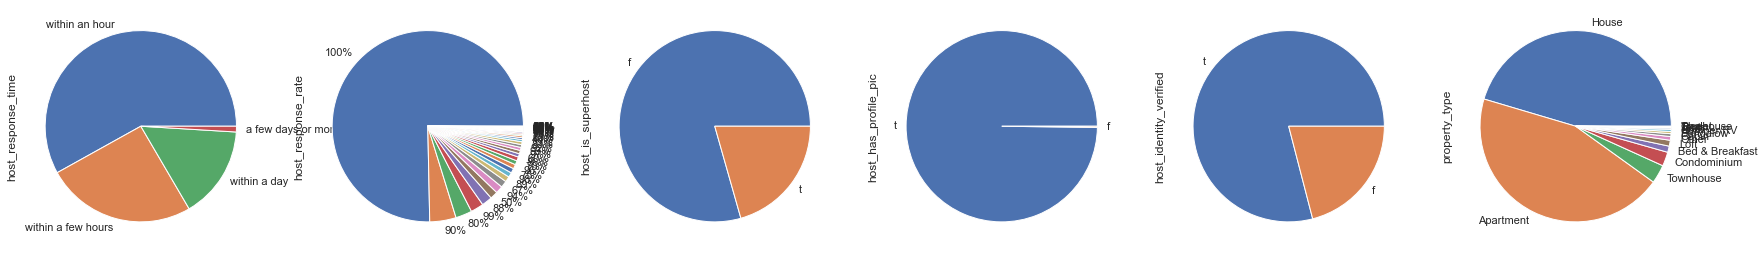

In [27]:
# plot pie
plt.figure(figsize=(5*len(key_mode), 5))
for i,key in enumerate(key_mode):
    plt.subplot(100+10*len(key_mode)+i+1)
    df_listings[key].value_counts().plot.pie(y=df_listings.columns[i+1])

here we see:
- several dummy-variables have very few data, they will be removed, if they have less than 100 occurences.
- 'host_has_profile_pic' will be removed, because there is not enough variation in the feature.
- these measures will help to prevent over-fitting


In [28]:
df_listings.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,...,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,polarity_scores
id,,,,,,,,,,,,,,,,,,,,,
241032,within a few hours,96%,100%,f,3.0,3.0,t,t,West Queen Anne,Queen Anne,...,9.0,10.0,f,f,moderate,f,f,2,4.07,0.883941
953595,within an hour,98%,100%,t,6.0,6.0,t,t,West Queen Anne,Queen Anne,...,10.0,10.0,f,f,strict,t,t,6,1.48,0.896686
3308979,within a few hours,67%,100%,f,2.0,2.0,t,t,West Queen Anne,Queen Anne,...,10.0,10.0,f,f,strict,f,f,2,1.15,0.885815
278830,within an hour,100%,NaN,f,2.0,2.0,t,t,West Queen Anne,Queen Anne,...,9.0,9.0,f,f,strict,f,f,1,0.89,0.836800
5956968,within an hour,100%,NaN,f,1.0,1.0,t,t,West Queen Anne,Queen Anne,...,10.0,10.0,f,f,strict,f,f,1,2.45,0.948647


In [29]:
# choose categorical values
df_listings = pd.get_dummies(df_listings, columns = key_mode, prefix_sep = '_d_')

we also create dummy-variables from 'anemety'

In [30]:
# create dummies from 'amenities'
# clean data
df_listings_a = clean_str(df_listings['amenities'])

# create anemety
df_listings_a_d = df_listings_a.str.get_dummies(sep=',')

# adapt columns, so that they can be handeld together with the other dummies
df_listings_a_d.columns = df_listings_a_d.columns.astype(str) + '_d_'

# join df_listings and df_listings_a_d
df_listings = df_listings.join(df_listings_a_d)

the available anemety are:

In [31]:
# all dummy-headers from 'anemety'
df_listings_a_d.columns

Index(['24-Hour Check-in_d_', 'Air Conditioning_d_', 'Breakfast_d_',
       'Buzzer/Wireless Intercom_d_', 'Cable TV_d_',
       'Carbon Monoxide Detector_d_', 'Cat(s)_d_', 'Dog(s)_d_', 'Doorman_d_',
       'Dryer_d_', 'Elevator in Building_d_', 'Essentials_d_',
       'Family/Kid Friendly_d_', 'Fire Extinguisher_d_', 'First Aid Kit_d_',
       'Free Parking on Premises_d_', 'Gym_d_', 'Hair Dryer_d_', 'Hangers_d_',
       'Heating_d_', 'Hot Tub_d_', 'Indoor Fireplace_d_', 'Internet_d_',
       'Iron_d_', 'Kitchen_d_', 'Laptop Friendly Workspace_d_',
       'Lock on Bedroom Door_d_', 'Other pet(s)_d_', 'Pets Allowed_d_',
       'Pets live on this property_d_', 'Pool_d_', 'Safety Card_d_',
       'Shampoo_d_', 'Smoke Detector_d_', 'Smoking Allowed_d_',
       'Suitable for Events_d_', 'TV_d_', 'Washer_d_', 'Washer / Dryer_d_',
       'Wheelchair Accessible_d_', 'Wireless Internet_d_'],
      dtype='object')

In [32]:
# all dummy-headers
dh = df_listings.columns[df_listings.columns.str.contains('_d_')]
dh

Index(['host_response_time_d_a few days or more',
       'host_response_time_d_within a day',
       'host_response_time_d_within a few hours',
       'host_response_time_d_within an hour', 'host_response_rate_d_100%',
       'host_response_rate_d_17%', 'host_response_rate_d_25%',
       'host_response_rate_d_31%', 'host_response_rate_d_33%',
       'host_response_rate_d_38%',
       ...
       'Safety Card_d_', 'Shampoo_d_', 'Smoke Detector_d_',
       'Smoking Allowed_d_', 'Suitable for Events_d_', 'TV_d_', 'Washer_d_',
       'Washer / Dryer_d_', 'Wheelchair Accessible_d_',
       'Wireless Internet_d_'],
      dtype='object', length=109)

these are to many dummy-variables. Remove the ones with low occurence-rates (<100)

In [33]:
# dummy-header with less that 100 ocurences
most_rel_cat = df_listings[dh].columns[df_listings[dh].sum() > 100]

all relevant dummy-variables are:

In [34]:
most_rel_cat

Index(['host_response_time_d_within a day',
       'host_response_time_d_within a few hours',
       'host_response_time_d_within an hour', 'host_response_rate_d_100%',
       'host_response_rate_d_90%', 'host_is_superhost_d_f',
       'host_is_superhost_d_t', 'host_has_profile_pic_d_t',
       'host_identity_verified_d_f', 'host_identity_verified_d_t',
       'property_type_d_Apartment', 'property_type_d_House',
       'property_type_d_Townhouse', '24-Hour Check-in_d_',
       'Air Conditioning_d_', 'Breakfast_d_', 'Buzzer/Wireless Intercom_d_',
       'Cable TV_d_', 'Carbon Monoxide Detector_d_', 'Cat(s)_d_', 'Dog(s)_d_',
       'Dryer_d_', 'Elevator in Building_d_', 'Essentials_d_',
       'Family/Kid Friendly_d_', 'Fire Extinguisher_d_', 'First Aid Kit_d_',
       'Free Parking on Premises_d_', 'Gym_d_', 'Hair Dryer_d_', 'Hangers_d_',
       'Heating_d_', 'Hot Tub_d_', 'Indoor Fireplace_d_', 'Internet_d_',
       'Iron_d_', 'Kitchen_d_', 'Laptop Friendly Workspace_d_',
       'Pets

we now have a set of relevant dummy-variables, that we want to use to train our model.
Now, as we have the most relevant numerical and categorical features, we can set up and train our model.

### Section 4: Modeling
A standard, linear model will be used.
Different approchas with differne input data will be used:
1. different numbers of only numerical features:
  - we will iterate throu 2 to 15 different features, to see which set will have the best train- and test-scores
2. additional categorical data
  - we will then add the categorical features, to see, if it improves.


In [35]:
# set up DataFrame for the results
result = pd.DataFrame(index = ['number of vars', 'train_score', 'test_score'])

# Instantiate linear regression model
lm_model = LinearRegression(normalize=True) 

for i in range(3,15):
    
    # take the i most relevant numerical features
    most_rel_num = df_listings_num_cov.sort_values(['price'],ascending = False).index[1:i].values
    
    #most_rel = np.append(most_rel_num,most_rel_cat)
    
    # define data sets
    X = df_listings[most_rel_num]
    y = df_listings['price']
    
    # Create train and test data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state=42) 
        
    # fit model to training data set
    lm_model.fit(X_train, y_train) 
            
    # Predict and score the model
    y_train_preds = lm_model.predict(X_train)
    y_test_preds = lm_model.predict(X_test) 
    train_score = r2_score(y_train, y_train_preds)
    test_score = r2_score(y_test,y_test_preds)
    
    result[str(i)] = [i,train_score,test_score]

In [36]:
most_rel_num


array(['accommodates', 'bedrooms', 'beds', 'bathrooms', 'guests_included',
       'host_total_listings_count', 'host_listings_count',
       'review_scores_location', 'review_scores_cleanliness',
       'review_scores_rating', 'review_scores_communication',
       'minimum_nights', 'review_scores_accuracy'], dtype=object)

we can see that even with 3 features the results are not to bad, but they get better if we use more features.  
Now we will add the categorical features to see, if the score will be better:

In [37]:
# take the 14 most relevant numerical features
most_rel_num = df_listings_num_cov.sort_values(['price'],ascending = False).index[1:14].values
most_rel = np.append(most_rel_num,most_rel_cat)
    
# define data sets
X = df_listings[most_rel]
y = df_listings['price']
    
# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state=42) 
        
# fit model to training data set
lm_model.fit(X_train, y_train) 
            
# Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test) 
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test,y_test_preds)
    
result[str(15)] = [i,train_score,test_score]

### Section 5: Evaluation

#### Question block 1: how ist the AirBnB market in Seattle?!
#### Question A: how many listings do exist?
can already be answered:

In [38]:
print("Number of listings: ", df_calendar.shape[0])

Number of listings:  1393570


### Question B: what ist the average price, how is its distribution over the year?
### Question C:what is the average availability, how is its distribution over the year?
To be able to answer the next questions, we need to sort the data by the month:

In [39]:
# only take 2016
df_calendar_16 = df_calendar[df_calendar['year'] == 2016]# groupby month

df_calendar_16_gb_p = df_calendar_16.groupby('month').mean()

So we get an overview about the price and availability per month:

In [40]:
print ("the average price in Seattle is:",df_calendar_16_gb_p['price'].mean(),"US$")

the average price in Seattle is: 132.30137880262683 US$


<AxesSubplot:xlabel='month'>

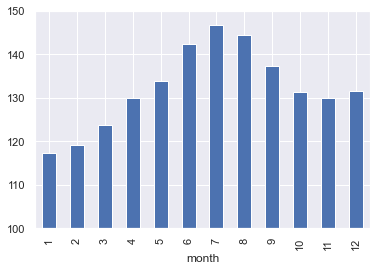

In [41]:
# barplots:
# price per month:
df_calendar_16_gb_p['price'].plot.bar(y = 'price in $', ylim = [100,150])

In [42]:
print ("the average availability in Seattle is:",df_calendar_16_gb_p['available'].mean()*100,"%")

the average availability in Seattle is: 66.93378631899787 %


<AxesSubplot:xlabel='month'>

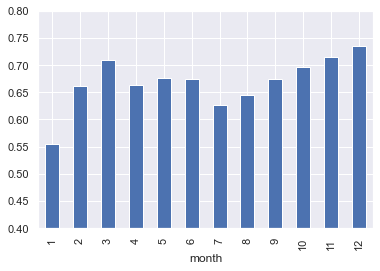

In [43]:
# availability per month:
df_calendar_16_gb_p['available'].plot.bar(y = 'relativ availability', ylim = [0.4,0.8]) 

### Question D: is there a correlation between price, availabilty and the climate in Seattle
To get an idea, when it is a good idea to travel to Seattle, we need to see these 2 plot together with weather data:

<AxesSubplot:xlabel='month'>

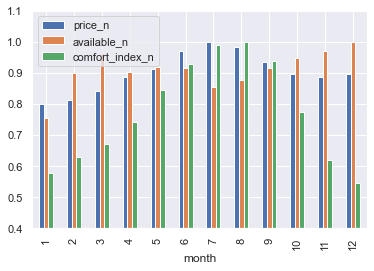

In [44]:
# get climate data from https://www.bestplaces.net/climate/city/washington/seattle
comfort_index = np.array([5.6,6.1,6.5,7.2,8.2,9,9.6,9.7,9.1,7.5,6,5.3])

# normalize price, availibility and comfort data for comparison
df_calendar_16_gb_p['comfort_index_n'] = comfort_index/max(comfort_index)
df_calendar_16_gb_p['price_n'] = df_calendar_16_gb_p['price']/df_calendar_16_gb_p['price'].max()
df_calendar_16_gb_p['available_n'] = df_calendar_16_gb_p['available']/df_calendar_16_gb_p['available'].max()

# plot comparison
df_calendar_16_gb_p[['price_n','available_n','comfort_index_n']].plot.bar(ylim = [0.4,1.1])

In this diagramm we can see a certain correlation between the price with the comfort-index. The best month to travel would be August, because only there the comfort-index is higher than the price ;-).
It also turns out that the availability doesn't seem to correlate to strong with the price or comfort-index.

### Question E: how ist the distribution of the listings over the neighborhoods and in general over the city in terms of numbers, prices, ratings and property type?
Besides the time-related behavior of the data it could be interesting to get more information about local differences.
For that we now turn to the listings-data-set.
First, let's get an overview about the over-all price-structure:

<AxesSubplot:ylabel='Frequency'>

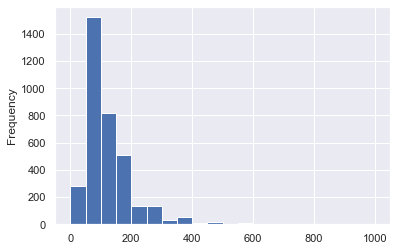

In [45]:
# histogram of price
df_listings['price'].plot.hist(bins=20)

we can see here, that the price of most of the listings is less than 400US$, so these listings will be shown in a geographical context:

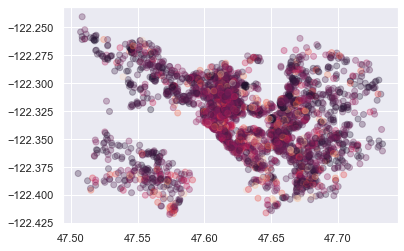

In [46]:
# price-distribution geographicly
# clip price, otherwise the color distribution is bad.
pr400 = df_listings['price'].clip(0,400)

# plot listings at their position
plt.scatter(df_listings.latitude, df_listings.longitude, c= pr400/pr400.max(), alpha=0.3)

the brighter a listing is, the more expensive it is. Apparently there are no "hot spots" with expensive listings.  
We also can look at neigborhoods.
How are the differences in term of price between the different neigborhoods?

<AxesSubplot:xlabel='neighbourhood_group_cleansed'>

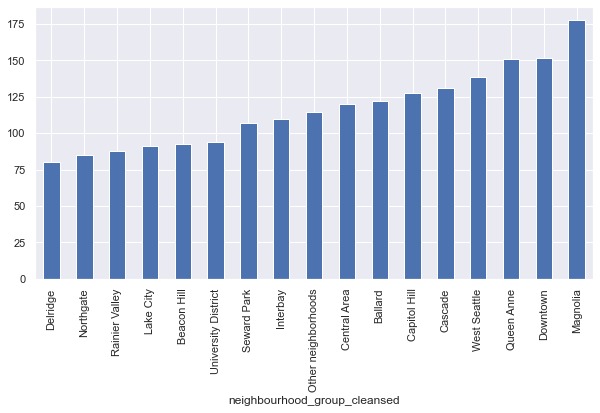

In [47]:
df_ng = df_listings.groupby(['neighbourhood_group_cleansed']).mean()['price'].sort_values()
df_ng.plot.bar(figsize=[10,5])

so we see that there are differences in the mean of the prices of the differend neigborhoods.  
But are they relevant?  
To find out, we show the distribution of the prices within the neigborhoods:

<AxesSubplot:xlabel='neighbourhood_group_cleansed', ylabel='price'>

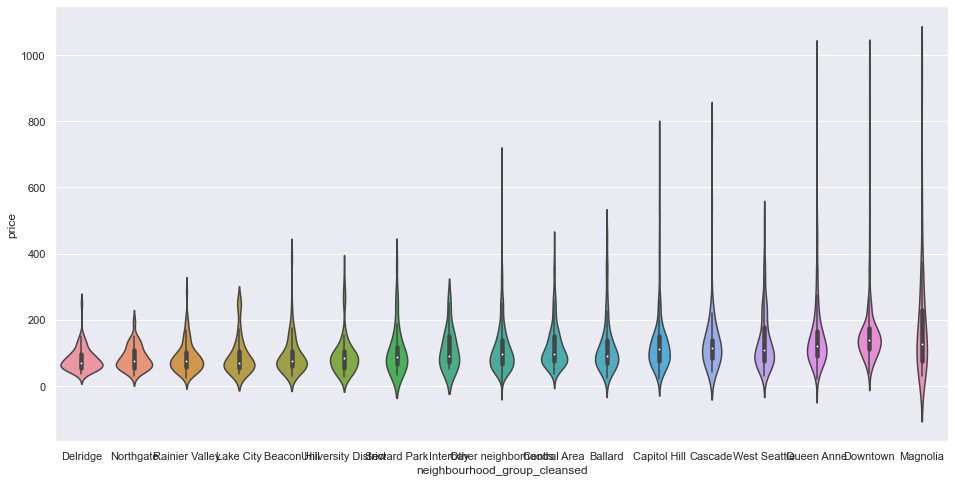

In [48]:
# visualize the variance of the prices in the neig.
sns.set(rc={'figure.figsize':(16,8)})
sns.violinplot(x="neighbourhood_group_cleansed", y="price", data=df_listings, order = df_ng.index)

so we see, that the variance of the prices is relativly high.  This shows, that the prices of the listing is well distributed over the neigborhoods. We have already seen that in our geographical overview.  
now let's see how many listings are in which neigborhoods:

<AxesSubplot:xlabel='neighbourhood_group_cleansed'>

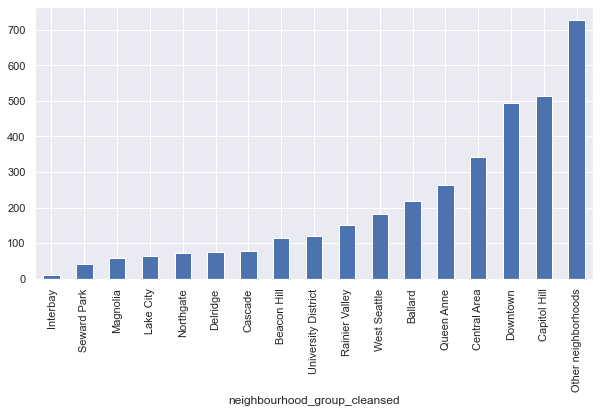

In [49]:
df_ng = df_listings.groupby(['neighbourhood_group_cleansed']).count()['review_scores_rating'].sort_values()
df_ng.plot.bar(figsize=[10,5])

And finaly, which neigborhood has the best ratings?

<AxesSubplot:xlabel='neighbourhood_group_cleansed'>

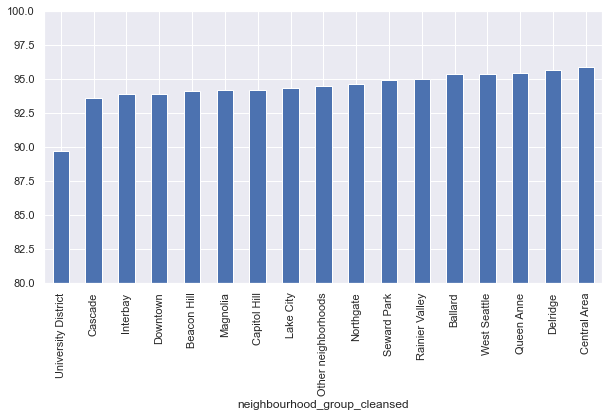

In [50]:
df_ng = df_listings.groupby(['neighbourhood_group_cleansed']).mean()['review_scores_rating'].sort_values()
df_ng.plot.bar(figsize=[10,5],ylim = [80,100])


## Question block 2: how can written reviews used for data analysis?
### Question is it possible to quantify them using a "SentimentIntensityAnalyzer"?
### Question what are the pitfalls if doing so?
Now we will deal also with the review data.
The general questions are:
- is it possible to process the human-written review data?
- will it help us in understanding the data?
We use the SentimentIntensityAnalyzer to translate the human-written reviews into polarity scores.
These scores can be between -1 and 1 and should represent the sentiment intensity of the reviewer. High rates shows a good feeling, low rates show bad feelings.

To get an idea, if the calculated polarity_scores make sense, we have a look at the TOP-10:

In [51]:
df_reviews[['polarity_scores', 'comments']].sort_values('polarity_scores', ascending = False)[:10]

,polarity_scores,comments
30896,0.9997,Awesome location about a mile from downtown Ba...
66184,0.9995,This was our third trip to Seattle to visit ou...
47251,0.9995,"Angela TOTALLY lived up to her ""reputation"" in..."
5188,0.9995,This was such a great trip and experience!\r\n...
66144,0.9994,If you are looking for a fabulous place to sta...
37491,0.9993,Our first ever Airbnb booking and we could not...
55862,0.9993,We flew into Seattle quite early to get our to...
22940,0.9992,It’s hard to describe how awesome our stay at ...
59500,0.9992,"My boyfriend, Jake and I visit Seattle on the ..."
34175,0.9992,This was my first Air BnB experience and could...


we can see, that the reviews with a high polarity_score indeed are positiv reviews.  
So we have a look at the Bottom-10:

In [52]:
df_reviews[['polarity_scores', 'comments']].sort_values('polarity_scores', ascending = True)[:10]

,polarity_scores,comments
50261,-0.9975,Wir sind 5 Nächte geblieben. Und es ist eine A...
29434,-0.9970,"leider war esnicht so fein, da die unterkunft ..."
84378,-0.9961,"Die Unterkunft war sehr schön und genau so, wi..."
32404,-0.9956,Melissa replied to our request and approved bu...
75564,-0.9941,Staying at Robert’s place was a nightmare. At ...
18347,-0.9927,Für den Aufenthalt in einer fremdem Stadt hatt...
22483,-0.9908,Beautiful Condo - Beware : NO AC!\nWe stayed a...
1786,-0.9892,Die Unterkunft ist so wie beschrieben und die ...
14908,-0.9885,Das Zimmer war wie beschrieben und die Umgebun...
32787,-0.9881,Die Ankunft war unkompliziert. Die Lage ist ru...


here we see some very bad review (e.g. "Staying at Robert’s place was a nightmare"), so that is fine.  
On the other hand, we see mostly German reviews. These are not specific bad, one is very good: "Die Unterkunft war sehr schön und genau so, wi..." (in english: "the appartment was very nice").  
So in this case, the SentimentIntensityAnalyzer didn't worked good, very likly because of the foreign language.
### Question C:is there a correlation between the polarity_scores from a SentimentIntensityAnalyzer and the direct rating scores from the customer?


In [53]:
# is there a correlation between polarity_scores of the reviews and the ratings of the listings?
rev_corr = df_listings['review_scores_rating'].corr(df_listings['polarity_scores'])
print ("the correlation between polarity_scores of the reviews and the ratings of the listings is:",rev_corr)

the correlation between polarity_scores of the reviews and the ratings of the listings is: 0.3844318918809194


We can have a look on the scatter-plot:

<AxesSubplot:xlabel='review_scores_rating', ylabel='polarity_scores'>

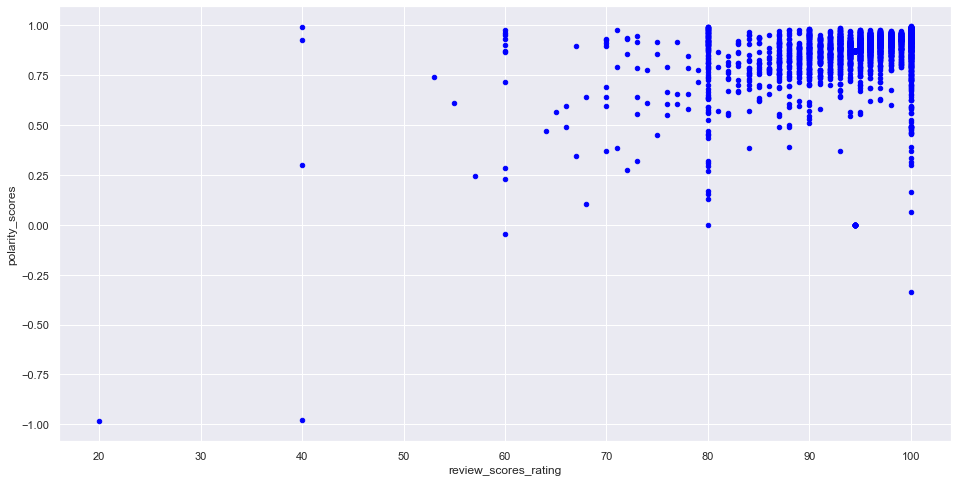

In [54]:
# scatterplot between polarity_scores of the reviews and the ratings of the listings
df_listings.plot.scatter(x='review_scores_rating', y='polarity_scores', c='Blue')

We see a correlation between the two scores, which shows, that:
- the SentimentIntensityAnalyzer works, and
- the ratings and the review of the customer are implied.
We can also see the correlation to the other ratings in the heatmap below.

### Question 3: how can the price be predicted using a data-based model?  
### - which data best fit to the model?
Finally we have a look at the coefficients of the model we created, to see the influence of these

In [55]:
def coef_weights(coefficients, X_train):
    '''
    Function to get coefficients back for each of the features
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(10)

,est_int,coefs,abs_coefs
22,host_identity_verified_d_t,-6.024009e+12,6.024009e+12
21,host_identity_verified_d_f,-6.024009e+12,6.024009e+12
19,host_is_superhost_d_t,3.931233e+11,3.931233e+11
18,host_is_superhost_d_f,3.931233e+11,3.931233e+11
6,host_listings_count,2.318276e+11,2.318276e+11
5,host_total_listings_count,-2.318276e+11,2.318276e+11
20,host_has_profile_pic_d_t,-3.377351e+01,3.377351e+01
1,bedrooms,2.795345e+01,2.795345e+01
3,bathrooms,2.199284e+01,2.199284e+01
35,Elevator in Building_d_,2.139542e+01,2.139542e+01


Now let's have a look at the results of linear model:  
- results number 3-14 are the scores of the linear model only using 3-14 numerical features. the more features we use, the better is the model. But too many feature would increase the danger of overfitting.  
- result number 15 uses 14 numerical features and also 6 categorical features. This model is better due to the information, it gets from the additional categorical features.

In [56]:
result

,3,4,5,6,7,8,9,10,11,12,13,14,15
number of vars,3.000000,4.00000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,14.000000
train_score,0.472220,0.47225,0.487692,0.491142,0.493129,0.493129,0.505077,0.505633,0.505658,0.506017,0.506070,0.506079,0.549676
test_score,0.473328,0.47284,0.479335,0.490136,0.487314,0.487314,0.492747,0.491426,0.490964,0.490845,0.491028,0.491041,0.569673


### Deployment

the deployment is done on https://medium.com/@stone12_49671/how-data-helps-on-vacation-9a82f65c1b1e